In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import multiprocessing
from scipy import signal
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from model_src.DilatedResNet import DilatedResNet
from model_src.BianResnet import BianResNet
from model_src.LSTM import VanillaLSTM, CNNLSTM, BiLSTM, BiLSTMAttn
from model_src.RespNet import RespNet

physical_devices = tf.config.list_physical_devices('GPU')
print(f'Is GPU Avaliable: {physical_devices[0]}')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
DATA_PATH = '/root/Workspace/DataLake/stMary'
DATA_SAVE_PATH = '/root/Workspace/Project-RRpo-2ndStudy/dataset' 

Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is GPU Avaliable: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [16]:
EPOCHS = 1000
BATCH_SIZE = 256
LR = 0.001
callbacks = [
    EarlyStopping(monitor='val_loss', patience=33),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
]

In [17]:
def gen_tfdataset(dataset, batchsize):
    X = []; y = []
    for pleth, resp in dataset:
        X.append(pleth.astype(np.float32))
        y.append(resp)

    X = np.array(X); y = np.array(y).reshape(-1,1)
    scaler = MinMaxScaler()
    scaled_X = np.asarray([scaler.fit_transform(pleth.reshape(-1,1)) for pleth in X])
    print(f'Overall: {scaled_X.shape}, {y.shape}')
    return tf.data.Dataset.from_tensor_slices((scaled_X, y)).batch(batchsize)

In [4]:
dataset = np.load(f'{DATA_SAVE_PATH}/230921/bidmc-trainval_dataset.npy', allow_pickle=True)
print(dataset.shape)

(43, 2)


In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# kf = KFold(n_splits=n_splits)
train_losses = []; val_losses = []
subject_id = np.array([subject[0] for subject in dataset])
count = 1

for i, idx in enumerate(kf.split(subject_id)):
    if i != 4: continue
    train_dataset = []; val_dataset = []
    for id, samples in dataset:
        if id in subject_id[idx[0]]: train_dataset.extend(samples)
        else: val_dataset.extend(samples)
    
    train_dataset = np.array(train_dataset); val_dataset = np.array(val_dataset)

    train_tf = gen_tfdataset(train_dataset, 256)
    val_tf = gen_tfdataset(val_dataset, 256)

Overall: (14735, 1800, 1), (14735, 1)
Overall: (3368, 1800, 1), (3368, 1)


In [11]:
val_pleth = np.concatenate([pleth.reshape(1,-1,1) for pleth, _ in val_dataset], axis=0)
val_resp = np.array([resp for _, resp in val_dataset]).reshape(-1,1)
val_pleth.shape, val_resp.shape

((3368, 1800, 1), (3368, 1))

In [2]:
load_model = DilatedResNet(num_of_blocks=4, kernel_size=2, dilation_rate=3, dwn_kernel_size=3, filters=8, strides_of_avg=2, units=86)
load_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=keras.metrics.MeanAbsoluteError()
)
load_model.load_weights(f"../models/230924/bidmc/DilatedResNet/DilatedResNet-bidmc-KF3/ckpt")

In [49]:
bian_pred_rr = load_model.predict(val_tf)
bian_pred_rr.shape, val_resp.shape, np.mean(np.abs(val_resp - bian_pred_rr))

14/14 [==============================] - 1s 9ms/step


((3368, 1), (3368, 1), 1.608422804898151)

In [47]:
respnet_pred_rr = load_model.predict(val_tf)
respnet_pred_rr.shape, val_resp.shape, np.mean(np.abs(val_resp - respnet_pred_rr))

14/14 [==============================] - 7s 177ms/step


((3368, 1), (3368, 1), 1.7007454268439648)

In [13]:
dil_pred_rr = load_model.predict(val_tf)
dil_pred_rr.shape, val_resp.shape, np.mean(np.abs(val_resp - dil_pred_rr))

14/14 [==============================] - 1s 20ms/step


((3368, 1), (3368, 1), 1.485233128778725)

## PCC

In [79]:
from scipy import stats

In [80]:
bian_r = stats.pearsonr(bian_pred_rr.reshape(-1), val_resp.reshape(-1), alternative='two-sided')
bian_r

PearsonRResult(statistic=-0.05193979599808122, pvalue=0.0025679717998504177)

In [81]:
respnet_r = stats.pearsonr(respnet_pred_rr.reshape(-1), val_resp.reshape(-1), alternative='two-sided')
respnet_r

PearsonRResult(statistic=-0.3210570387028325, pvalue=1.3094305320639105e-81)

In [82]:
dil_r = stats.pearsonr(dil_pred_rr.reshape(-1), val_resp.reshape(-1), alternative='two-sided')
dil_r

PearsonRResult(statistic=0.5069308363383596, pvalue=2.1280747186597192e-219)

## Bar plot

In [117]:
import matplotlib.pyplot as plt
from scipy.stats import bartlett, ttest_ind

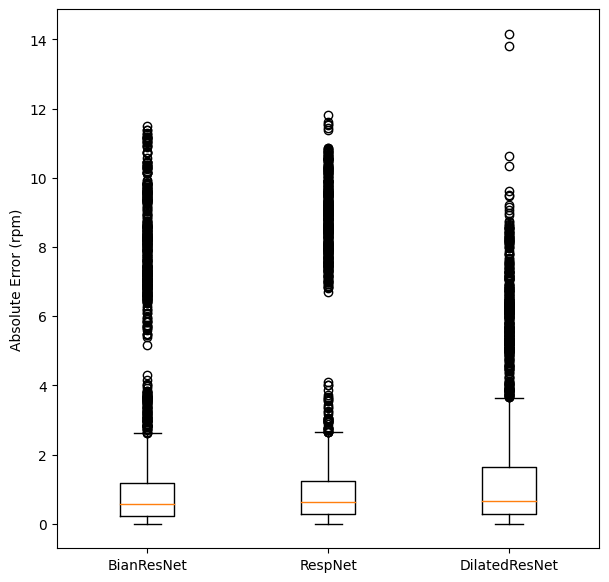

[array([0.2362175, 0.0004406]), array([1.18794441, 2.61253929]), array([2.7703476e-01, 3.6239624e-05]), array([1.22402048, 2.64184761]), array([0.28225994, 0.00094414]), array([1.63122797, 3.62897682])]
[array([0.58432102, 0.58432102]), array([0.63928986, 0.63928986]), array([0.6503191, 0.6503191])]
531 464 454


In [78]:
plt.figure(figsize=(7,7))
box_err = plt.boxplot([np.abs(val_resp-bian_pred_rr).reshape(-1), np.abs(val_resp-respnet_pred_rr).reshape(-1), np.abs(val_resp-dil_pred_rr).reshape(-1)])
plt.xticks([1,2,3], ['BianResNet', 'RespNet', 'DilatedResNet'])
# plt.xlabel('Data Type')
plt.ylabel('Absolute Error (rpm)')
plt.show()

whiskers = [item.get_ydata() for item in box_err['whiskers']]
medians = [item.get_ydata() for item in box_err['medians']]
fliers = [item.get_ydata() for item in box_err['fliers']]

print(whiskers)
print(medians)
print(len(fliers[0]), len(fliers[1]), len(fliers[2]))

## plot

In [137]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# kf = KFold(n_splits=n_splits)
train_losses = []; val_losses = []
subject_id = np.array([subject[0] for subject in dataset])
count = 1

for i, idx in enumerate(kf.split(subject_id)):
    if i != 2: continue
    train_id = []; val_id = []
    for id, samples in dataset:
        if id in subject_id[idx[0]]: train_id.append(id)
        else: val_id.append(id)
    
    train_id = np.array(train_id); val_id = np.array(val_id)

In [138]:
val_id

array(['bidmc_02', 'bidmc_09', 'bidmc_17', 'bidmc_20', 'bidmc_25',
       'bidmc_35', 'bidmc_38', 'bidmc_39', 'bidmc_52'], dtype='<U8')

In [184]:
bidmc_sj = list(filter(lambda d: d[0]==val_id[2], dataset))
bidmc_sj[0][1].shape

(421, 2)

In [185]:
bidmc_sjtf = gen_tfdataset(bidmc_sj[0][1], 256)

Overall: (421, 1800, 1), (421, 1)


In [186]:
b_pleth = np.array([pleth.reshape(-1,1) for pleth, resp in bidmc_sj[0][1]])
b_resp = np.array([resp for pleth, resp in bidmc_sj[0][1]]).reshape(-1,1)
b_pleth.shape, b_resp.shape

((421, 1800, 1), (421, 1))

In [187]:
b_pred_rr = load_model.predict(bidmc_sjtf)
b_pred_rr.shape, b_resp.shape, np.mean(np.abs(b_resp - b_pred_rr))

2/2 [==============================] - 0s 23ms/step


((421, 1), (421, 1), 0.5846812776035482)

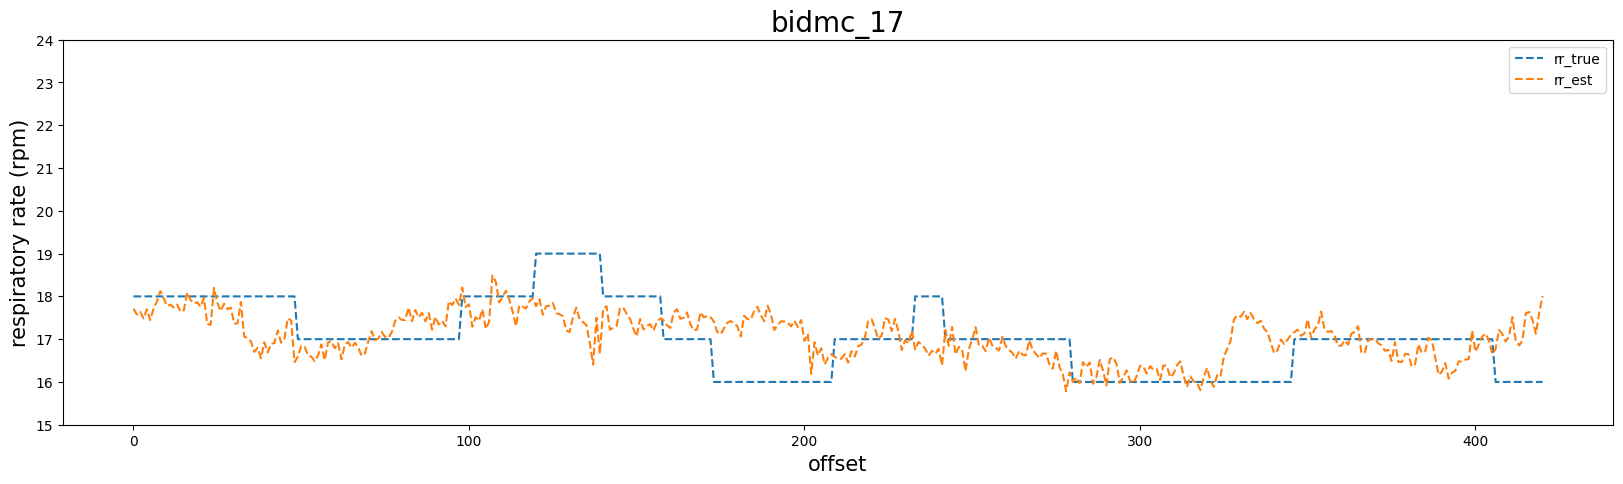

In [193]:
plt.figure(figsize=(20,5))
plt.plot(b_resp, linestyle='--', label='rr_true')
plt.plot(b_pred_rr, linestyle='--', label='rr_est')
plt.yticks(np.arange(15,25))
plt.legend()
plt.ylabel('respiratory rate (rpm)', fontsize=15)
plt.xlabel('offset', fontsize=15)
plt.title(f'{val_id[2]}', fontsize=20)
plt.savefig('../../Fig_rr.png')
plt.show()

# Test

In [164]:
def get_trainable_X(dataset):
    scaler = MinMaxScaler()
    return np.expand_dims(scaler.fit_transform(np.vstack(dataset[:, 0])),axis=-1)


def get_resp_class(dataset):
    rapid_rr = []; normal_rr = []; slow_rr = []
    for id, samples in dataset:
        for sample in samples:
            if sample[1] < 12: slow_rr.append(sample)
            elif sample[1] > 20: rapid_rr.append(sample)
            else: normal_rr.append(sample)
    
    rapid_rr = np.array(rapid_rr)
    normal_rr = np.array(normal_rr)
    slow_rr = np.array(slow_rr)
    return rapid_rr, normal_rr, slow_rr


def get_predict_performance(model, X, y):
    y_pred = model.predict(X)
    return y - y_pred

In [163]:
load_model = DilatedResNet(num_of_blocks=4, kernel_size=2, dilation_rate=3, dwn_kernel_size=3, filters=8, strides_of_avg=2, units=86)
load_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=keras.metrics.MeanAbsoluteError()
)
load_model.load_weights(f"../models/230924/bidmc/DilatedResNet/DilatedResNet-bidmc-KF5/ckpt")

In [182]:
test_dat = np.load('../dataset/test_dataset/bidmc-test_dataset.npy', allow_pickle=True)
test_dat2 = np.load('../dataset/230920/stmary-preprocessed.npy', allow_pickle=True)
test_dat3 = np.load('../dataset/test_dataset/capno-preprocessed.npy', allow_pickle=True)
test_dat.shape, test_dat2.shape, test_dat3.shape

((7, 2), (100, 2), (13, 2))

In [187]:
rapid, normal, slow = get_resp_class(test_dat2)
test_dat = np.concatenate([rapid, normal, slow],axis=0)
X_test, y_test = get_trainable_X(test_dat), test_dat[:, 1].reshape(-1,1)
X_test.shape, y_test.shape

((6508, 1800, 1), (6508, 1))

In [188]:
error = get_predict_performance(load_model, X_test, y_test)
abs_err = np.abs(error)

204/204 [==============================] - 2s 10ms/step


In [189]:
print(f'{np.mean(np.abs(error)):.4f} ± {np.std(np.abs(error)):.4f}')

4.3177 ± 3.3040


In [190]:
print(len(abs_err[np.where(abs_err <= 5)])/len(abs_err))

0.629379225568531


In [ ]:
pred_resp = load_model.predict(test_pleth)
pred_resp.shape

In [95]:
test_dataset = []
for test in test_dat:
    test_dataset.append(test[1])

test_dataset = np.concatenate(test_dataset, axis=0)
test_dataset.shape

(2947, 2)

In [156]:
test_dataset = []
for test in test_dat2:
    test_dataset.append(test[1])

test_dataset = np.concatenate(test_dataset, axis=0)
test_dataset.shape

(6508, 2)

In [132]:
test_dataset = []
for test in test_dat3:
    test_dataset.append(test[1])

test_dataset = np.concatenate(test_dataset, axis=0)
test_dataset.shape

(5473, 2)

In [157]:
test_tf = gen_tfdataset(test_dataset, 256)

Overall: (6508, 1800, 1), (6508, 1)


In [147]:
test_pleth = []; test_resp = []
for t in test_dataset:
    test_pleth.append(t[0])
    test_resp.append(t[1])

In [159]:
# test_pleth = np.expand_dims(np.vstack(test_pleth), axis=-1)
test_pleth = get_trainable_X(test_pleth)
test_resp = np.array(test_resp).reshape(-1,1)
test_pleth.shape, test_resp.shape

((6508, 1, 1), (6508, 1))

In [149]:
pred_resp = load_model.predict(test_pleth)
pred_resp.shape

204/204 [==============================] - 3s 11ms/step


(6508, 1)

In [150]:
load_model.evaluate(test_tf)

26/26 [==============================] - 1s 32ms/step - loss: 3.6948 - mean_absolute_error: 3.6948


[3.694826126098633, 3.694826126098633]

In [151]:
np.mean(np.abs(test_resp - pred_resp)), np.std(np.abs(test_resp - pred_resp))

(13897.880895510289, 11752.510942786328)

In [152]:
error = np.abs(test_resp - pred_resp)

In [153]:
print(len(error[np.where(error <= 5)])/len(error))

0.0
